# Tagup: Data Science Challenge
### Time Series Analysis

In [1]:
# To help you get started...
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Data Loading

This is a brief analysis based on Machine 5 and the time series from column '0'. 

In [2]:
data = pd.read_csv('exampleco_data/machine_5.csv')
data.columns = ['Time', '0', '1', '2', '3']
data.set_index('Time', inplace=True)
data.index = pd.to_datetime(data.index)

In [3]:
data.head(30)

,0,1,2,3
Time,,,,
2019-01-01 00:00:00.000000000,12.597777,8.836901,-11.799889,10.089948
2019-01-01 08:00:09.603201067,10.831517,2.812573,11.559953,271.895841
2019-01-01 16:00:19.206402134,21.070489,-0.652446,-17.842786,-1.347411
2019-01-02 00:00:28.809603201,32.301228,6.542094,-13.497374,-4.269658
2019-01-02 08:00:38.412804268,28.065453,3.693814,21.984687,13.624739
2019-01-02 16:00:48.016005335,29.638135,-3.528300,3.374230,-3.004207
2019-01-03 00:00:57.619206402,38.911840,1.908587,-10.835078,-17.735347
2019-01-03 08:01:07.222407469,33.049210,3.197697,25.478492,1.129042
2019-01-03 16:01:16.825608536,25.188107,-5.462976,22.952913,-3.451812


In [4]:
def plot_time_series(df):
    '''
    Plots all the 4 time series of the machine in a grid.
    
    PARAMETERS:
    df (pandas.core.frame.DataFrame): Dataset containing the 4 time series in 4 separate columns named '0', '1', '2' and '4'.

    RETURNS:
    None
    '''
    
    plt.figure(figsize = (15, 5))
    plt.subplot(2, 2, 1)
    plt.plot((df.index), df['0'])
    plt.subplot(2, 2, 2)
    plt.plot(df.index, df['1'])
    plt.subplot(2, 2, 3)
    plt.plot(df.index, df['2'])
    plt.subplot(2, 2, 4)
    plt.plot(df.index, df['3'])   

# Time Series: Before Noise Removal

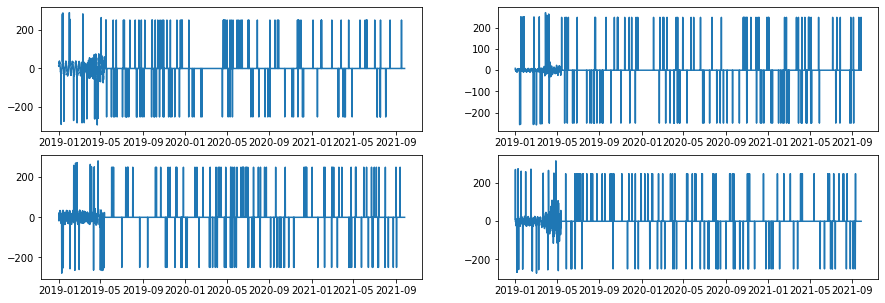

In [5]:
plot_time_series(data)

Looks like a lot of spikes in all the time series. Will have to remove this noise first before moving on to the next steps.

# Time Series: After Noise Removal

In [6]:
def remove_outliers(df):
    '''
    Remove noise content in the time series using rolling median method.
    
    PARAMETERS:
    df (pandas.core.frame.DataFrame): Dataset containing the 4 time series in 4 separate columns named '0', '1', '2' and '4'.

    RETURNS:
    df (pandas.core.frame.DataFrame): Cleaned dataset with the same structure as the input dataset.
    '''
    
    for i in range(4):
        data = df[str(i)]
        up_limit = data.mean() + (2 * data.std())
        down_limit = data.mean() - (2 * data.std())
        for j in range(len(data)): 
            if(data[j] > up_limit or data[j] < down_limit):
                if(j > 5):
                    data[j] = data[j-5:j+5].median()
                else:
                    data[j] = data[j:j+5].median()
        df[str(i)] = data  
    return df        

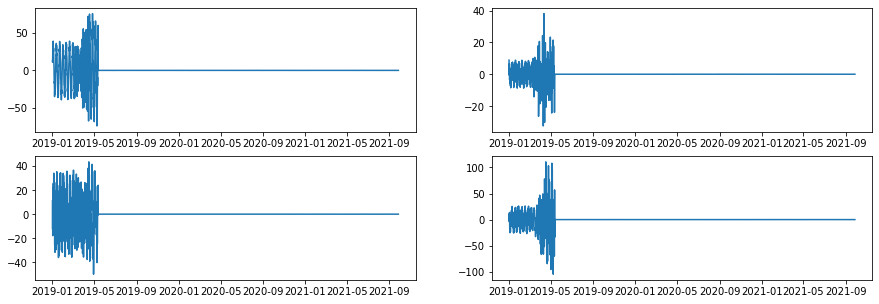

In [7]:
clean_data = remove_outliers(data)
plot_time_series(clean_data)

Looks pretty neat.

# Finding the Fault and Failure Points

In [8]:
def find_sudden_change(df, window, col_name, threshold):
    '''
    Find the sudden change point in the plot of rolling standard deviation. 
    This method basically compares standard deviation of the current window with its predecesor 
    and checks if it is significantly different based on a threshold. 
    Also, plots the rolling standard deviation after the sudden change point.
    
    
    PARAMETERS:
    df (pandas.core.frame.DataFrame): Dataset containing the 4 time series in 4 separate columns named '0', '1', '2' and '4'.
    window (int): Length of the desired window.
    col_name (str): Column name.
    threshold (float): Threshold to compare standard deviation amongst succesive windows.

    RETURNS:
    sudden_change_pt (int): Row number of the window's start point where sudden change occured.
    '''
    # Rolling Standard Deviation for the whole time series
    roll_std = df.rolling(window = window).std() 
    plt.figure(figsize = (15, 5))
    df[col_name].plot()
    roll_std[col_name].plot()
    plt.title('Rolling Standard Deviation')
    
    previous_win_std = np.std(roll_std[window:window * 2][col_name])
    
    for i in range(window * 2, len(roll_std), window):   
        current_win_std = roll_std[i:i+window][col_name].std()    
        if(current_win_std > (threshold * previous_win_std)):
            sudden_change_pt = i
            print('Sudden Change Point: ', sudden_change_pt)
            plt.figure(figsize = (15, 5))
            df[col_name].plot()
            roll_std[sudden_change_pt:][col_name].plot()
            plt.title('Plot of Time Series after the Sudden Change Point')
            break
        else:
            previous_win_std = current_win_std
            sudden_change_pt = i
    return sudden_change_pt
    

## Fault Point

Sudden Change Point:  180


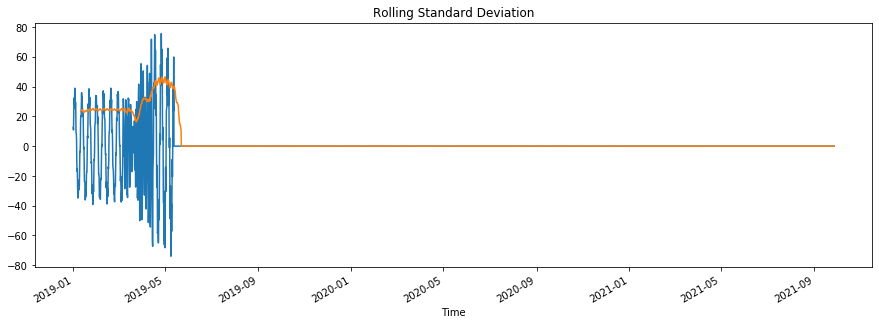

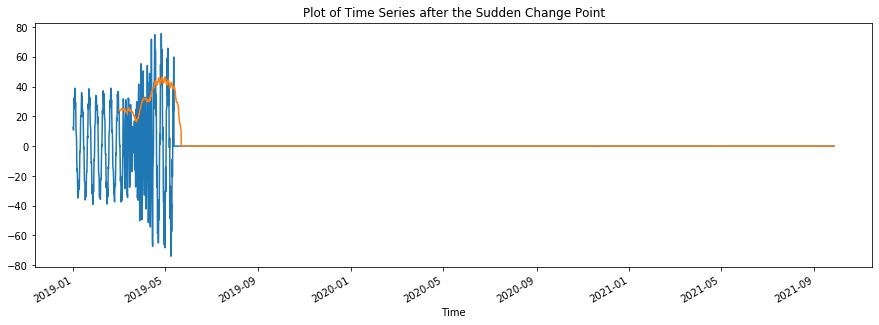

In [9]:
fault_mode_pt = find_sudden_change(clean_data, 30, '0', 1.5)

In [10]:
print("The fault occured on the following date: ", clean_data[fault_mode_pt:fault_mode_pt + 1].index)

The fault occured on the following date:  DatetimeIndex(['2019-03-02 00:28:48.576192064'], dtype='datetime64[ns]', name='Time', freq=None)


## Failure Point

In [11]:
faulty_df = clean_data[fault_mode_pt:]

Sudden Change Point:  220


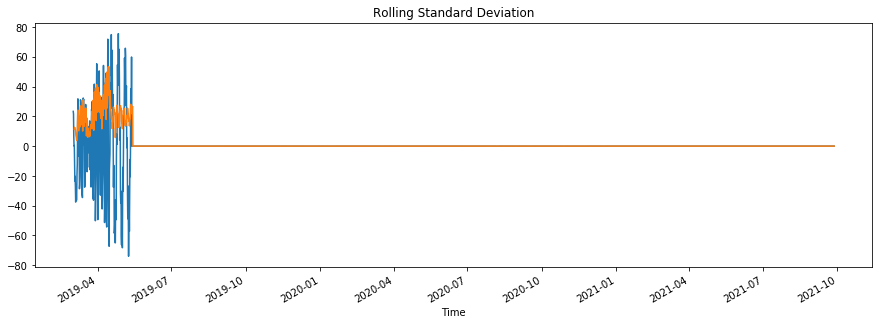

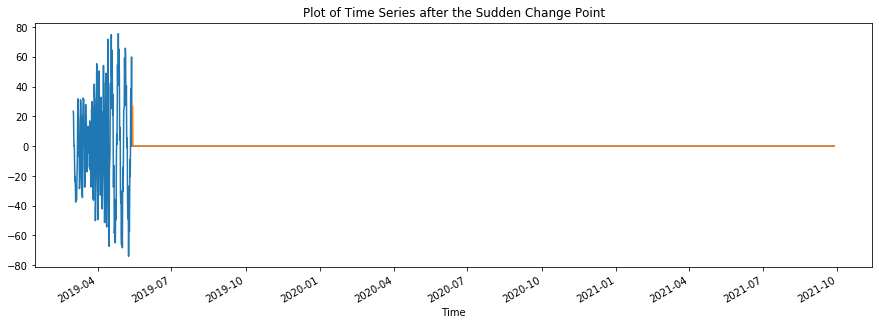

In [12]:
failure_mode_pt = find_sudden_change(faulty_df, 5, '0', 5)

In [13]:
failure_mode_pt = failure_mode_pt + fault_mode_pt
print("The machine failed to operate completely on the following date: ", clean_data[failure_mode_pt:failure_mode_pt + 1].index)

The machine failed to operate completely on the following date:  DatetimeIndex(['2019-05-14 09:04:01.280426810'], dtype='datetime64[ns]', name='Time', freq=None)


# Observations

* This analysis was just based on a single time series of a single machine. I was planning to do it for all the machines and all the time series by writing a class for the code but it would mean that there would be a LOT of plots and I wanted to keep it simple. 


* The Noise Removal process works well on all the data. I did try it for all the machines and it performs pretty well.


* The code works very well in detecting the 'Fault Point' as I have tried and found the results to be pretty good for all the machines.


* The code however sometimes struggles in finding the accurate 'Failure Point'. But it is only for some machines and works well for most of the machines.


* Things that I thought of trying:
    - Using a Time Series Forecasting Model to forecast the Time Series and then simply check the difference of my predictions and the actual values. 
    - Using Anamoly Detection methods. 
    
    
* I came up with these methods and found them to be really easy to understand and interpret with decent performance and hence went with them anyway.


Note: You could simply change the filename in the block where I load the data and check for whichever data you want to. I would strongly recommend it!

Thank you for this opportunity. whatever the outcome might be, I really had fun working on this problem and would really appreciate your feedback on this. If you would like, do check out some of my other work here on GitHub. 